In [1]:
# ----------------------------------------------------------

# Filtrado y reconstrucción
# ----------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from skimage import data, color, img_as_float
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
import os

# Rutas
os.makedirs("../reports", exist_ok=True)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["image.cmap"] = "gray"


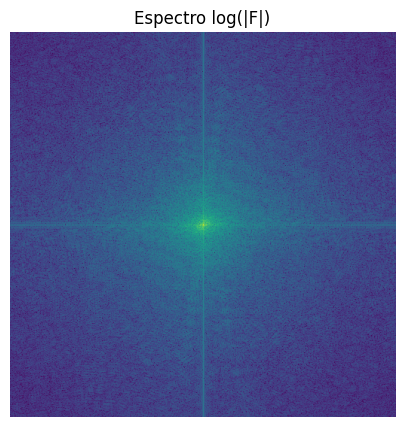

In [2]:
img = img_as_float(color.rgb2gray(data.astronaut()))
M, N = img.shape

F = fftshift(fft2(img))
S = np.abs(F)

plt.imshow(np.log1p(S), cmap="viridis")
plt.title("Espectro log(|F|)")
plt.axis("off")
plt.show()


In [3]:
u = np.arange(-M//2, M//2)
v = np.arange(-N//2, N//2)
U, V = np.meshgrid(u, v, indexing='ij')
R = np.sqrt(U**2 + V**2)  # radio en frecuencia


In [4]:
def ideal_lowpass(R, r0):
    """Filtro pasa-bajas ideal: mantiene frecuencias <= r0."""
    return (R <= r0).astype(float)

def ideal_highpass(R, r0):
    """Filtro pasa-altas ideal."""
    return (R > r0).astype(float)

def gaussian_lowpass(R, r0):
    """Filtro pasa-bajas Gaussiano."""
    return np.exp(-(R**2) / (2*(r0**2)))

def butterworth_lowpass(R, r0, n=2):
    """Filtro Butterworth de orden n."""
    return 1 / (1 + (R/r0)**(2*n))


In [5]:
def apply_filter_and_reconstruct(F, H):
    """Aplica filtro H en frecuencia y reconstruye la imagen."""
    Ffilt = F * H
    img_rec = np.real(ifft2(ifftshift(Ffilt)))
    return img_rec

r0 = 50  # radio de corte (ajustable)

filters = {
    "Ideal LP": ideal_lowpass(R, r0),
    "Ideal HP": ideal_highpass(R, r0),
    "Gaussian LP": gaussian_lowpass(R, r0),
    "Butterworth LP": butterworth_lowpass(R, r0, n=3)
}

reconstructions = {name: apply_filter_and_reconstruct(F, H) for name, H in filters.items()}


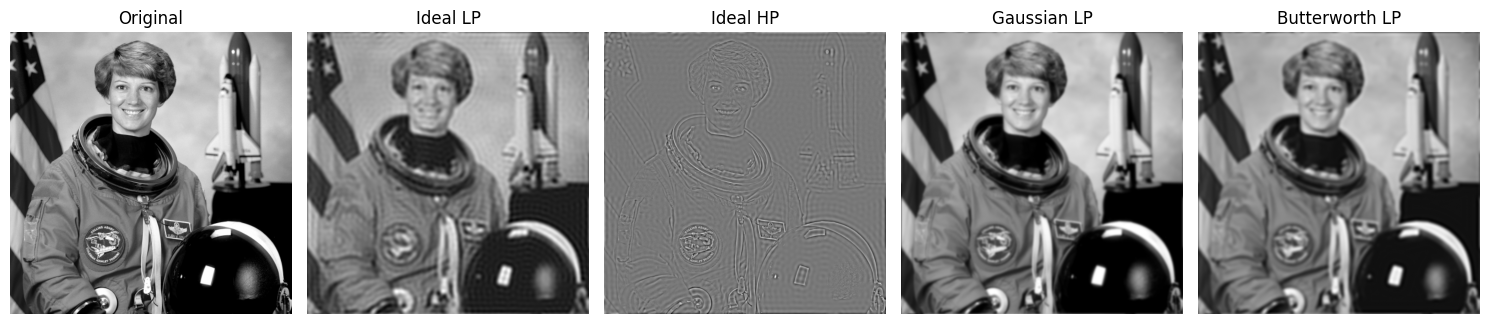

In [6]:
fig, ax = plt.subplots(1, 5, figsize=(15,4))
ax[0].imshow(img); ax[0].set_title("Original"); ax[0].axis("off")

for i, (name, rec) in enumerate(reconstructions.items(), 1):
    ax[i].imshow(rec)
    ax[i].set_title(name)
    ax[i].axis("off")

plt.tight_layout()
plt.show()


In [13]:
import numpy as np
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity

def prepare_image_for_metrics(img):
    """Asegura dtype float y rango [0,1] para evaluar."""
    arr = np.asarray(img, dtype=float)
    # Si tiene valores fuera de [0,1], los recortamos.
    # Si prefieres normalizar en vez de recortar, reemplaza clip por normalización (comentado abajo).
    arr = np.clip(arr, 0.0, 1.0)
    # --- alternativa: normalizar dinámicamente (descomentar si lo prefieres)
    # mn, mx = arr.min(), arr.max()
    # if mx > mn:
    #     arr = (arr - mn) / (mx - mn)
    return arr

def evaluate(original, reconstructed, data_range=None):
    """
    Devuelve (mse, psnr, ssim).
    - Asegura que ambos arrays sean float y estén en [0,1] (recortando).
    - Calcula data_range automáticamente si no se entrega.
    """
    orig = prepare_image_for_metrics(original)
    rec  = prepare_image_for_metrics(reconstructed)

    # Verificar dimensiones iguales
    if orig.shape != rec.shape:
        raise ValueError(f"Shapes no coinciden: original {orig.shape}, reconstructed {rec.shape}")

    # data_range por defecto
    if data_range is None:
        dr = orig.max() - orig.min()
        if dr == 0:
            dr = 1.0
        data_range = dr

    mse = mean_squared_error(orig, rec)
    psnr = peak_signal_noise_ratio(orig, rec, data_range=data_range)
    ssim = structural_similarity(orig, rec, data_range=data_range, channel_axis=None)

    return mse, psnr, ssim

# Uso: iterar sobre reconstructions (diccionario)
for name, rec in reconstructions.items():
    try:
        mse, psnr, ssim = evaluate(img, rec)
        print(f"{name:15s}  MSE={mse:.6f}  PSNR={psnr:.2f} dB  SSIM={ssim:.4f}")
    except Exception as e:
        print(f"Error evaluando {name}: {e}")


import pandas as pd

rows = []
for name, rec in reconstructions.items():
    mse, psnr, ssim = evaluate(img, rec)
    rows.append({"filter": name, "mse": mse, "psnr": psnr, "ssim": ssim})

df_metrics = pd.DataFrame(rows)
print(df_metrics)
df_metrics.to_csv("../reports/metrics_filters.csv", index=False)

Ideal LP         MSE=0.004001  PSNR=23.98 dB  SSIM=0.7105
Ideal HP         MSE=0.263981  PSNR=5.78 dB  SSIM=0.1388
Gaussian LP      MSE=0.002687  PSNR=25.71 dB  SSIM=0.8636
Butterworth LP   MSE=0.003385  PSNR=24.70 dB  SSIM=0.8168
           filter       mse       psnr      ssim
0        Ideal LP  0.004001  23.978660  0.710532
1        Ideal HP  0.263981   5.784278  0.138846
2     Gaussian LP  0.002687  25.707683  0.863580
3  Butterworth LP  0.003385  24.704821  0.816756


In [9]:
def energy_from_spectrum(F):
    return np.sum(np.abs(F)**2)

E_total = energy_from_spectrum(F)
for name, H in filters.items():
    E_filtered = energy_from_spectrum(F * H)
    print(f"{name:15s}  Energía retenida: {E_filtered/E_total:.3f}")


Ideal LP         Energía retenida: 0.986
Ideal HP         Energía retenida: 0.014
Gaussian LP      Energía retenida: 0.974
Butterworth LP   Energía retenida: 0.982


In [11]:
plt.imsave("../reports/filtered_comparison.png", np.concatenate(
    [img] + [reconstructions[k] for k in reconstructions.keys()], axis=1), cmap="gray")

os.makedirs("../diary", exist_ok=True)
with open("../diary/filtering_notes.md", "a", encoding="utf-8") as f:
    f.write("\n---\nSemana 2 — Filtrado y reconstrucción\n")
    f.write(f"Radio de corte: r0 = {r0}\n")
    f.write("Comparación de métricas y energía retenida.\n")
